# Titanic: Machine Learning from Disaster
Chad Heaps
March 2018

Exploring different features and models in my first Kaggle project. The submission at the end of this notebook has a public score of 0.79425.  I think my biggest room for improvement is in data pre-processing and feature engineering/selection.

Thanks to the Kaggle forums and public notebooks for a lot of help.  Also, a lot of help and some of the code came from Hands-on Machine Learning by Aurélien Géron http://shop.oreilly.com/product/0636920052289.do and the associated Notebooks at https://github.com/ageron/handson-ml


## Overview of data  from Kaggle

The data has been split into two groups:  
training set (train.csv)  
test set (test.csv)  
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.  

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.  

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.  

Data Dictionary  
Variable	Definition	Key  
survival	Survival	0 = No, 1 = Yes  
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
sex	Sex	  
Age	Age in years	  
sibsp	# of siblings / spouses aboard the Titanic	  
parch	# of parents / children aboard the Titanic	  
ticket	Ticket number	  
fare	Passenger fare	  
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton  
Variable Notes  
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5  

sibsp: The dataset defines family relations in this way...  
Sibling = brother, sister, stepbrother, stepsister  
Spouse = husband, wife (mistresses and fiancés were ignored)  

parch: The dataset defines family relations in this way...  
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.  

In [1]:
import copy
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import sparse
from scipy.stats import randint, uniform


from pandas.plotting import scatter_matrix

#Matplotlib related imports
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import pylab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns

#Various Scikit-learn imports
#Pre-processing and such
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array


#Fitting algorithms
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#Scoring utilities, etc.
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, log_loss, auc, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.utils.validation import check_is_fitted
plt.rcParams['patch.force_edgecolor'] = True #Add lines to bars in histograms

rng = 42
np.random.seed(rng)

In [2]:
df = pd.read_csv('train.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
live_total = df['Survived'].sum()
dead_total = df.shape[0] - live_total
print('Out of {} passengers (in the train set), {} survived'.format(df.shape[0], 
                                                 live_total))
print('This is {: 6.2f}% in total'.format(100.*(live_total / df.shape[0])))

Out of 891 passengers (in the train set), 342 survived
This is  38.38% in total


### A little EDA

In [6]:
dead_df = df.loc[df['Survived'] == 0, :].copy()
live_df = df.loc[df['Survived'] == 1, :].copy()

In [7]:
df.corr()['Survived']

Survived    1.000000
Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

Unsurprisingly, Passenger Class and Fare are strongly correlated with survival.  In the next cell, we map Sex to a numerical value and see it is also strongly correlated.

In [8]:
pd.concat([pd.get_dummies(df['Sex']), df.Survived], axis=1).corr()['Survived']

female      0.543351
male       -0.543351
Survived    1.000000
Name: Survived, dtype: float64

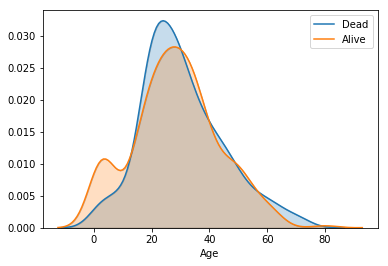

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.kdeplot(dead_df['Age'].dropna().values, shade=True, label='Dead', ax=ax)
sns.kdeplot(live_df['Age'].dropna().values, shade=True, label='Alive', ax=ax)
ax.set_xlabel('Age')
ax.set_label('Kernel Density Estimate')
plt.legend()
plt.show()

Do things change appreciably if we fill the NAs with the mean?  Not really.

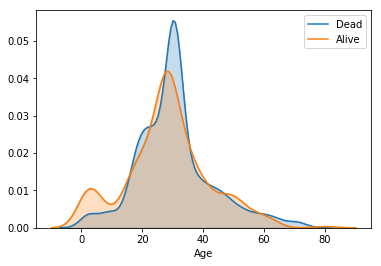

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.kdeplot(dead_df['Age'].fillna(dead_df.Age.mean()).values, shade=True, label='Dead', ax=ax)
sns.kdeplot(live_df['Age'].fillna(live_df.Age.mean()).values, shade=True, label='Alive', ax=ax)
ax.set_xlabel('Age')
ax.set_label('Kernel Density Estimate')
plt.legend()
plt.show()

Much of the distribution is similar, although being very young evidently helped survival.  Still, less compelling than I might expect

#### Family size



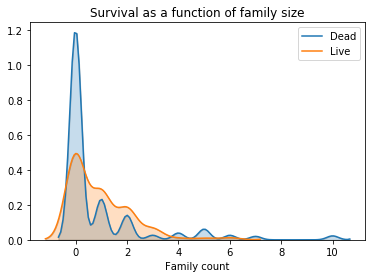

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.kdeplot((dead_df.SibSp.fillna(dead_df.SibSp.mean()).values 
             + dead_df.Parch.fillna(dead_df.Parch.mean()).values), 
            shade=True, label='Dead', ax=ax)
sns.kdeplot((live_df.SibSp.fillna(live_df.SibSp.mean()).values 
             + live_df.Parch.fillna(live_df.Parch.mean()).values), 
            shade=True, label='Live', ax=ax)
ax.set_title('Survival as a function of family size')
ax.set_xlabel('Family count')

plt.legend()
plt.show()

Having some family appears to help somewhat.  Right now, I have the options of using a Boolean feature as to whether Family size is > 0 or to use it as a continuous variable (although only integer values are present)

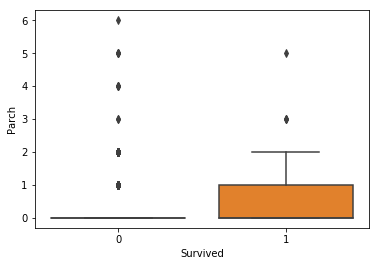

In [12]:
ax = sns.boxplot(x='Survived', y='Parch', data=df)
plt.show()

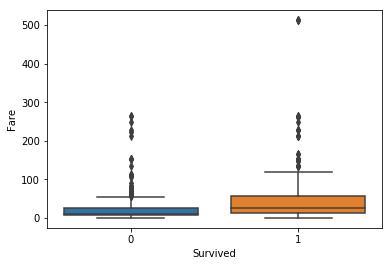

In [13]:
ax = sns.boxplot(x='Survived', y='Fare', data=df)
plt.show()

## Train/Test split and functions for data processing

In [14]:
label = ['Survived']

X = df.drop(label, axis=1)
Y = df.drop([col for col in df.columns if col not in label], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                    stratify = Y.values, 
                                                    random_state = rng)
y_train = y_train.values.reshape(-1)
y_test = y_test.values.reshape(-1)
y_tot = Y.values.reshape(-1)

#### Various functions and classes written to make my custom pre-processing compatible with sklearn pipeline

In [15]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """
    This comes from Hands-on Machine Learning by Aurélien Géron
    http://shop.oreilly.com/product/0636920052289.do
    Create a class to select numerical or categorical columns 
    Haven't looked into the sklearn-pandas module yet
    Should be at beginning of a given pipeline
    """
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].copy()

class DataFrameExtractor(BaseEstimator, TransformerMixin):
    """
    Extract the numeric data from the transformed DataFrame
    This should be the last pipeline step before sklearn preprocessing
    Will also store the final set of column names as a parameter for 
    easy access when evaluating feature contributions to model
    """
    def __init__(self, colParams = None):
        self.colParams = colParams
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        self.colParams = X.columns.tolist()
        return X.values.copy().astype(np.float)

class Prep_category(BaseEstimator, TransformerMixin):
    """
    Pipeline compatible class to convert DataFrame of 
    character data into encoded data suitable for learning algorithms
    Uses pandas get_dummies for encoding
    
    There are alternatives to pandas get_dummies.
    
    With get_dummies, I have set drop_first = True, which removes one of the
    OneHot category columns.  This was after checking the pearson-r values and 
    seeing the redundancy.  The ill-conditioning is a problem for models
    https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn
    
    1) CategoricalEncoder: This requires code from 
    https://github.com/scikit-learn/scikit-learn/pull/9151
    and is used in the Hands-on ML github notebooks.

    ce = CategoricalEncoder(encoding='onehot-dense')
    ce.fit_transform(df['Pclass'].values.reshape(-1,1))

    2) Using native sklearn functionality.
    le = LabelEncoder()
    le.fit(df['Pclass'])
    class_ints = le.transform(df['Pclass'])
    
    To achieve one-hot encoding like get_dummies, add this
    
    enc = OneHotEncoder(sparse = False)
    enc.fit(class_ints.reshape(-1,1))
    enc.transform(class_ints.reshape(-1,1))
    
    I am still learning about different methods to encode
    categorical data.
    
    method = 'OneHot' uses get_dummies
    method = 'LabelEncoder' 
    
    OneHot creates a column for each possible value with a value of 0 or 1.
    As an example, the data for the original Sex and the transformed data is
    array([['male', 1, 0],
           ['female', 0, 1],
           ['female', 0, 1],
           ['female', 0, 1],
           ['male', 1, 0]])
           
    The LabelEncoder gives a single column with 0-(n_classes - 1) specifying the
    category.  Using the column Embarked, which has three possibilities, looks like this
    array([['S', 2],
           ['C', 0],
           ['S', 2],
           ['S', 2],
           ['S', 2],
           ['Q', 1],
           ['S', 2],
           ['S', 2],
           ['S', 2],
           ['C', 0]],)
    """
    
    def __init__(self, drop_first = True, method = 'OneHot', 
                 cat_modes = None):
        self.method = method
        self.cat_modes = cat_modes
        self.drop_first = drop_first
        return
    def fit(self, X, y=None):
        temp_df = X.copy()
        self.cat_modes = {}
        for i_col in temp_df.columns.tolist():
            self.cat_modes[i_col] =  temp_df[i_col].value_counts().idxmax()
        return self
    def transform(self, X):
        temp_df = X.copy()
        for i_col in temp_df.columns.tolist():
            if temp_df[i_col].isnull().sum():
                temp_df.loc[temp_df[i_col].isnull(),i_col] = (self.cat_modes
                                                              [i_col])
                
            temp_df[i_col] = temp_df[i_col].astype('category')
            if self.method == 'OneHot':
                i_df = pd.get_dummies(temp_df[i_col], 
                                      prefix=i_col,
                                      drop_first = self.drop_first)
                temp_df = pd.concat([temp_df, i_df], axis=1)
            elif self.method == 'LabelEncoder':
                le = LabelEncoder()
                arr = le.fit_transform(temp_df[i_col])
                series1 = pd.Series(data=arr, 
                                    index=temp_df.index, dtype='category', 
                                    name = i_col + 'Encode')
                temp_df = pd.concat([temp_df, series1], axis=1)
                
            temp_df.drop(i_col, axis = 1, inplace = True)
        return temp_df
  
    
class Deck_add(BaseEstimator, TransformerMixin):
    """
    I have split up fit and transform so that I can find the proper
    fillna values from the train set that will be used on the test set.
    The point is to run fit_transform on the train to determine fill_vals,
    then when transform is called on the test data, it fills in the most 
    frequent deck from the test set.
    The code is a little redundant but should get the job done.
    
    It does assume that every passenger has a Pclass.
    """
    def __init__(self, fill_vals = None):
        self.fill_vals = fill_vals
        self.allowed_decks = ['A','B','C','D','E','F']
    def fit(self, X, y=None):
        temp_df = X.copy()
        
        cabin_df = temp_df.loc[temp_df['Cabin'].notnull(), :]
        deck_series =pd.Series(index=temp_df.index, dtype=str)
        for i,j in cabin_df.iterrows():
            deck_series.loc[i] = j['Cabin'].split()[0][0]
            if deck_series.loc[i] not in self.allowed_decks:
                deck_series.loc[i] = np.nan

        temp_df = temp_df.assign(Deck = deck_series.values)
        self.fill_vals = (temp_df.groupby(
                                        ['Deck', 'Pclass']
                                        )
                                        .size()
                                        .unstack(fill_value=0)
                                        .idxmax()
                         )
        return self
    def transform(self, X):
        temp_df = X.copy()
        cabin_df = temp_df.loc[temp_df['Cabin'].notnull(), :]
        deck_series = pd.Series(index=temp_df.index, dtype=str)
        for i,j in cabin_df.iterrows():
            deck_series.loc[i] = j['Cabin'].split()[0][0]
            if deck_series.loc[i] not in self.allowed_decks:
                deck_series.loc[i] = np.nan

        temp_df = temp_df.assign(Deck = deck_series.values)
        null_inds = temp_df.loc[temp_df['Cabin'].isnull()].index
        for i in null_inds:
            temp_df.loc[i, 'Deck'] = self.fill_vals.loc[temp_df.loc[i, 'Pclass']]
        return temp_df

def split_ticket(df, inplace = False):
    """
    A function to parse the ticket numbers from Titanic passengers.
    I do not know how to interpret the numbers, but I have split them
    into the preceding character strings (if present) and the
    integer number at the end (if present).
    
    The ticket numbers are highly unstructured in that they have a variety of
    lengths, letters, and what appear to be typos in some of the preceding
    characters such as 'stono' vs. 'sotono'.  
    
    I do not think I will try to fit the ticket features for now.
    
    If inplace == True, return df updated 
    else if inplace == False, return a modified copy of df
    
    """
    find_int = re.compile('[0-9]+')
    find_char = re.compile('([a-zA-Z].?\/?[0-9]*\.?)+\D')
    if inplace == False:
        temp_df = df.copy()
    else:
        temp_df = df
    
    if 'Ticket_char' in temp_df:
        temp_df.drop('Ticket_char', axis = 1, inplace = True)
    if 'Ticket_number' in temp_df:
        temp_df.drop('Ticket_number', axis = 1, inplace = True)
    temp_df['Ticket_char'] = ''
    temp_df['Ticket_number'] = 0
        
    for i,j in temp_df['Ticket'].iteritems():
        csearch = find_char.search(j)
        isearch = find_int.findall(j)
        if csearch:
            temp_df.loc[i, 'Ticket_char'] = csearch.group()
        if isearch:
            temp_df.loc[i, 'Ticket_number'] = int(isearch[-1])
    #Lowercase ticket characters and remove non-alphanumeric characters
    temp_df['Ticket_char'] = temp_df['Ticket_char'].str.lower()
    temp_df['Ticket_char'] = (temp_df['Ticket_char'].
                              str.replace('[^a-zA-Z0-9]', ''))
    if inplace == True:
        return
    elif inplace == False:
        return temp_df

Some functions for scoring, plotting, etc.

Some of these are adopted from Hands-on ML, too

In [16]:
def print_classifier_scores(model, x_train, y_train, x_test, y_test):
    """
    Prints the scores and standard deviations for the train 
    and test sets for a given fit.
    Assumes 'fit' has been called on the model and the model 
    has a score function.
    """
    train_score = model.score(x_train, y_train)   
    test_score  = model.score(x_test, y_test)
    print('Training set score = {: 6.4f}'.format(train_score))
    print('Testing set score  = {: 6.4f}'.format(test_score))
    
    logloss_train = log_loss(y_train, model.predict(x_train))
    logloss_test = log_loss(y_test, model.predict(x_test))

    print('Training set log loss = {: 6.4f}'.format(logloss_train))
    print('Testing set log loss  = {: 6.4f}'.format(logloss_test))
    return   

def print_cv_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    return

def print_grid_search_results(grid_search, X_attribs, 
                       x_train, y_train,
                       x_test, y_test, verbose=0):

    print('Best score using scoring metric '
          'from CV {: 8.5f}'.format(grid_search.best_score_))
    print('Score in train data from best parameters {: 8.5f}'
          .format(grid_search.best_estimator_.score(x_train, y_train)))
    print('Score on test data from best parameters {: 8.5f}'
          .format(grid_search.best_estimator_.score(x_test, y_test)))
    print('Parameters for best score in CV {}\n'
          .format(grid_search.best_params_))
    if verbose & hasattr(grid_search.best_estimator_, 'feature_importances_'):
        feature_importances = grid_search.best_estimator_.feature_importances_
        list_feature = sorted(zip(feature_importances, X_attribs))
        print('Feature importance for best scoring parameters')
        for i in list_feature:
            print('Feature/Importance: {:s} {: 8.5f}'.format(i[1], i[0]))
    if verbose:
        cvres = grid_search.cv_results_
        print('\nMean score and parameters')
        for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
            print(mean_score, params)
            
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

#### Functions wrapping some common model evaluation tools

Some of these are modified from the Hands-on ML book

In [17]:
def model_eval(model, X_train, y_train, X_test, y_test):
    """
    A simple wrapper function to quickly evaluate a model's performance
    on the train and test sets
    """
    print('Evaluating ' + str(model.__class__).strip('>')
                                              .strip('\'')
                                              .split('.')[-1])
    
    clf = copy.deepcopy(model)
    #clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print('Train score: {: 8.5f} '  
          ' Test score: {: 8.5}  '
          'Difference {: 8.5}'.format(train_score, 
                                      test_score, 
                                      train_score - test_score))
    
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print('Mean score on train set from 10-fold CV: {: 8.5f} '
          '  Std. Dev.: {: 8.5f}'.format(scores.mean(), scores.std()))
    return    

In [18]:
#Boolean of whether passenger has cabin assignment
Cabin_bool = FunctionTransformer(lambda x : 
                                 x.assign(Cabin_bool = x['Cabin'].notnull()),
                                 validate = False)                                    
#Boolean of whether passenger has Parch or SibSp
Family_bool = FunctionTransformer(lambda x : 
                                  x.assign(Family_bool = 
                                           (x['Parch'].fillna(0) > 0) 
                                           | (x['SibSp'].fillna(0) > 0)),
                                 validate = False)  
#Just Siblings/Spouses
SibSp_bool = FunctionTransformer(lambda x : 
                                  x.assign(
                                      SibSp_bool = (
                                                  x['SibSp'].fillna(0) > 0)
                                                    ),
                                 validate = False)  
#Just parents/children
Parch_bool = FunctionTransformer(lambda x : 
                                  x.assign(
                                      Parch_bool = (
                                                  x['Parch'].fillna(0) > 0)
                                                    ),
                                 validate = False) 
#Count family members as Parch + SibSp
Family_total = FunctionTransformer(lambda x : 
                                   x.assign(Family_total = 
                                            (x['Parch'].fillna(0) 
                                             + x['SibSp'].fillna(0))),
                                 validate = False) 
def sharedticket(xx):
    temp1 = split_ticket(xx)
    ticket_counts = pd.value_counts(temp1['Ticket_number'])
    temp_series = temp1['Ticket_number'].apply(lambda xt : 1                                                           
                                                          if ticket_counts[xt] > 1 
                                                          else 0)
    return xx.assign(Shared_ticket = temp_series)
Shared_ticket = FunctionTransformer(sharedticket, validate=False)   

#Name Lengh
Name_len = FunctionTransformer(lambda x : x.assign(Name_len = 
                                                   df['Name'].str.len()), 
                               validate=False)


These functions should take care of most of my pipeline fitting needs.  They allow easy transformation of data sets to test different features and pre-processing

In [19]:
def construct_pipeline(cat_attrs = [None], num_attrs = [None], 
                  cat_encode = 'OneHot', imputer_strat = 'median',
                  num_scaling = 'std_scaler', drop_cat_first = True, **kwargs):
    """
    Given a list of numerical and categorial attributes, construct a pipeline
    to process data.
    
    This will make testing different parameters easier
    
    Input:
    cat_attributes: 
                    List of categorical attributes to use in ML model.
                    These may be columns in the original DataFrame or
                    engineered features if you have constructed an appropriate
                    FunctionTransformer class and added it as
                    if 'Feature' in cat_attributes:
                    at the beginning of the pipeline creation
    num_attributes:
                    List of numerical attributes.  Same general idea as
                    categorical_attributes although an sklearn Imputer is 
                    used to fill NA values and either StdScaler or 
                    MinMaxScaler is used to scale data.
                
    cat_encode:
                Default = 'OneHot'.
                This option defines encoding of categorial attributes.
                'OneHot': 
                        Construct a new Boolean column for each category
                        of each feature.  All values are binary (0 or 1)
                'LabelEncoder':
                        Retains a single column for each categorial
                        attribute.  Each label is encoded with a value
                        between 0 and n_categories-1.
                        Warning: When n_categories > 2, the encoded data
                        will take on values  other than (0, 1).  ML algorithms
                        may treat adjacent encodings as being more similar, 
                        which is not necessarily the case.  
                        When 'LabelEncoder' is selected, the features are
                        scaled using MinMaxScaler to maintain (0,1) interval
    impute_strat:
                Default = 'median'
                The Imputer strategy for sklearn.preprocessing.Imputer
                Median is often fine, but refer to the sklearn documentation
                for more options
    
    Output:
            full_pipeline: An instance of sklearn.pipeline.FeatureUnion
                An sklearn Transformer that concatenates the categorical
                and numerical features.  
                Methods (from sklearn documentation):
                    fit(X[,y])
                    fit_transform(X[, y])
                    get_feature_names()
                    get_params([deep])
                    set_params(**kwargs)
                    transform(X)
                Use fit_transform on train data.
                Use transform (not fit_transform!) on test data
                to 
                See sklearn documentation for additional details
                
    """
    #Fill in options specified in kwargs.  Doing this added some flexibility
    #from just the optional arguments
    for arg, val in kwargs:
        if arg == 'cat_attrs':
            cat_attrs = val
        if arg == 'num_attrs':
            num_attrs = val 
        if arg == 'cat_encode':
            cat_encode = val
        if arg == 'imputer_strat':
            imputer_strat = val
        if arg == 'num_scaling':
            num_scaling = val
        if arg == 'drop_cat_first':
            drop_cat_first == val
    
    cat_pipe = []
    #Add classes for engineered features first
    if 'Deck' in cat_attrs:
        cat_pipe.append(('Deck', Deck_add()))
    if 'Cabin_bool' in cat_attrs:
        cat_pipe.append(('cabin_bool', Cabin_bool))
    if 'Family_bool' in cat_attrs:
        cat_pipe.append(('family_bool', Family_bool))
    if 'Shared_ticket' in cat_attrs:
        cat_pipe.append(('shared_ticket', Shared_ticket))
    if 'Family_total' in cat_attrs:
        cat_pipe.append(('Family_total', Family_total))  
    #Extract those features from the full pipeline
    cat_pipe.append(('selector', DataFrameSelector(cat_attrs)))
    #Transform selected features to ML-friendly form, either
    #Encoded as OneHot features or done with LabelEncoder which implies
    #ordering in the categorial variables.
    cat_pipe.append(('encode', Prep_category(drop_cat_first, 
                                             method=cat_encode)))
    cat_pipe.append(('extractor', DataFrameExtractor()))
    #Renormalize LabelEncoder features so that hey are between 0 and 1
    if cat_encode == 'LabelEncoder':
        cat_pipe.append(('minmax_scaler', MinMaxScaler()))
    cat_pipeline = Pipeline(cat_pipe)
    
    num_pipe = []
    #Add engineered numerical features
    if 'Family_total' in num_attrs:
        num_pipe.append(('Family_total', Family_total))
    if 'Name_len' in num_attrs:
        num_pipe.append(('name_len', Name_len))   
    num_pipe += [
                 ('selector', DataFrameSelector(num_attrs)), 
                 ('extractor', DataFrameExtractor()),
                 ('imputer', Imputer(strategy=imputer_strat)),
                ]
    if num_scaling == 'std_scaler':
        num_pipe += [('std_scaler', StandardScaler())]
    elif num_scaling == 'minmax_scaler':
        num_pipe += [('minmax_scaler', MinMaxScaler())]
        
    num_pipeline = Pipeline(num_pipe)
    #Join the two pipelines for full data preparation
    full_pipeline = FeatureUnion(
                            transformer_list=[("num_pipeline", num_pipeline),
                                              ("cat_pipeline", cat_pipeline),
                                              ])

    return full_pipeline

def fit_pipelines(model_dict, X_train, X_test, df, inplace=True, verbose=True):
    """
    A function takesa  dictionary of features and options for the pipeline,
    constructs the pipeline and fits.  
    
    Returns the updated dictionary by default but can return copy with
    inplace=False
    
    """
    
    if inplace == True:
        models = model_dict
    else:
        models = copy.deepcopy(models)

    for model, params in models.items():
        print('Fitting model ', model)
        models[model]['pipeline'] = construct_pipeline(**params)
        #Apply fit_transform to training data.  Saves hyperparameters for
        #pipeline construction
        models[model]['X_train'] = models[model]['pipeline'].fit_transform(
                                                            X_train)
        #Call transform to use training set hyperparameters in test set prep
        models[model]['X_test'] = models[model]['pipeline'].transform(
                                                            X_test)
        #For convenience and analysis, get the feature names and make a 
        #DataFrame out of the test set
        columns = ((models[model]['pipeline'].get_params()
                   ['num_pipeline__extractor__colParams'])
                + (models[model]['pipeline'].get_params()
                  ['cat_pipeline__extractor__colParams']))
        
        models[model]['df'] = pd.DataFrame(data = models[model]['X_train'], 
                                columns = columns,
                                index=X_train.index)
        models[model]['n_features'] = models[model]['df'].shape[1]
        models[model]['X_attribs'] = columns
        #Since the dataframe will only be used for analysis, I will attach the 
        #Survived column back on it
        models[model]['df'] = models[model]['df'].assign(Survived=df.loc[
                                                    models[model]['df'].index, 
                                                    'Survived'])
        if verbose:
            print('Correlation coefficients of features with survival')
            print(models[model]['df'].corr()['Survived'])
            print('')
    if inplace == True:
        return
    else:
        return models


## Model construction

To expedite evaluation of features, I will use a dictionary of different feature sets and hyperparameters for the pipeline.  It should allow easy comparison of features.


### Selecting categorial encoding and Numerical rescaling
In this first test, I just want an idea of how the different encodings and rescaling options work, so the same features will be used in all cases.

There is the possibility that different categorial features may be better suited for different encodings, but for now I use a single encoding each time.

In [20]:
models = {}
models['set1'] = {}
#A solid set of features from previous experience
models['set1']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 'Cabin_bool']
models['set1']['num_attrs'] = ['Fare', 'Age', 'Family_total']
models['set1']['cat_encode'] = 'OneHot'
models['set1']['num_scaling'] = 'std_scaler'

#Switch to LabelEncoder
models['set2'] = {}
models['set2']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 'Cabin_bool']
models['set2']['num_attrs'] = ['Fare', 'Age', 'Family_total']
models['set2']['cat_encode'] = 'LabelEncoder'
models['set2']['num_scaling'] = 'std_scaler'

#Switch to minmax_scaler
models['set3'] = {}
models['set3']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 'Cabin_bool']
models['set3']['num_attrs'] = ['Fare', 'Age', 'Family_total']
models['set3']['cat_encode'] = 'OneHot'
models['set3']['num_scaling'] = 'minmax_scaler'

#Switch to both
models['set4'] = {}
models['set4']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 'Cabin_bool']
models['set4']['num_attrs'] = ['Fare', 'Age', 'Family_total']
models['set4']['cat_encode'] = 'LabelEncoder'
models['set4']['num_scaling'] = 'minmax_scaler'


In [21]:
fit_pipelines(models, X_train, X_test, df, verbose=0)

Fitting model  set1
Fitting model  set2
Fitting model  set3
Fitting model  set4


In [22]:
for model, params in models.items():
    print('GridSearch for model: ', model)
    param_grid = [
                {'C':np.linspace(0.1, 6., 200)},
                 ]
    grid_search = GridSearchCV(LogisticRegression(random_state = rng),
                               param_grid, 
                               cv= 10, 
                               n_jobs = 1,
                               scoring= 'neg_log_loss')
    grid_search.fit(params['X_train'], y_train)
    print_grid_search_results(grid_search, params['X_attribs'],
                              params['X_train'], y_train,
                              params['X_test'], y_test, verbose=0)


GridSearch for model:  set1
Best score using scoring metric from CV -0.44130
Score in train data from best parameters  0.81461
Score on test data from best parameters  0.80447
Parameters for best score in CV {'C': 1.0190954773869347}

GridSearch for model:  set2
Best score using scoring metric from CV -0.44143
Score in train data from best parameters  0.81882
Score on test data from best parameters  0.79888
Parameters for best score in CV {'C': 1.7603015075376887}

GridSearch for model:  set3
Best score using scoring metric from CV -0.44217
Score in train data from best parameters  0.82022
Score on test data from best parameters  0.79330
Parameters for best score in CV {'C': 3.3316582914572868}

GridSearch for model:  set4
Best score using scoring metric from CV -0.44137
Score in train data from best parameters  0.81320
Score on test data from best parameters  0.79888
Parameters for best score in CV {'C': 4.9623115577889445}



While they are all very similar, my first choice would have been OneHot and std_scaler and this offers no reason to depart from that choice.  Additionally, the regularization parameter is larger and I will happily keep that smaller to keep the decision function smoother.

# Feature selection with cross-validation

1.  Model selection:  Out of curiosity, I will try some of the common classification algorithms
    - LogisticRegression
    - SVM classifier
    - Random Forest
    - K-nearest Neighbors
2.  Metrics
    - I will primarily use accuracy, but may look into the confusion matrix, precision/recall score, or ROC-curve
3.  Parameter optimization
    - Use 10-fold cross validation with GridSearch to find best parameters


### Possible features
1. Categorial
    - Deck
    - Cabin_bool
    - Family_bool
    - Shared_ticket (if ticket is not unique)
    - Sex
    - Pclass
    - Embarked (not used in any of my models)
2.  Numerical
    - Fare
    - Age
    - Name_len
3. Could be either (family counts)
    - SibSp
    - Parch
    - Family_total (SiSp + Parch)

In [23]:
models = {}
models['set1'] = {}
#All features
models['set1']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 'Cabin_bool', 'Family_bool',
                              'Shared_ticket']
models['set1']['num_attrs'] = ['Fare', 'Age', 'Family_total', 'Name_len']
models['set1']['cat_encode'] = 'OneHot'
models['set1']['num_scaling'] = 'std_scaler'

#Minimal set of effective features
models['set2'] = {}
models['set2']['cat_attrs'] = ['Pclass', 'Sex']
models['set2']['num_attrs'] = ['Fare', 'Age']
models['set2']['cat_encode'] = 'OneHot'
models['set2']['num_scaling'] = 'std_scaler'

#A moderate collection, the ones used in the preliminary check
models['set3'] = {}
models['set3']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 'Cabin_bool']
models['set3']['num_attrs'] = ['Fare', 'Age', 'Family_total']
models['set3']['cat_encode'] = 'OneHot'
models['set3']['num_scaling'] = 'std_scaler'

#One last variation
models['set4'] = {}
models['set4']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 
                               'Family_bool', 'Cabin_bool']
models['set4']['num_attrs'] = ['Fare', 'Age']
models['set4']['cat_encode'] = 'OneHot'
models['set4']['num_scaling'] = 'std_scaler'

#Fit all models
fit_pipelines(models, X_train, X_test, df, verbose=0)

Fitting model  set1
Fitting model  set2
Fitting model  set3
Fitting model  set4


## Logistic Regression
The principal parameter to optimize is C, the regularization parameter:   
Small C = Strong regularization   
May also select L1 or L2 norm  

In some other preliminary work, the L1 estimator was not appreciably better and the scores are noisier as a function of C, so I will restrict my choices to L2

GridSearch for model:  set1
Best score using scoring metric from CV -0.44179
Score in train data from best parameters  0.82303
Score on test data from best parameters  0.81006
Parameters for best score in CV {'C': 0.6040201005025125}



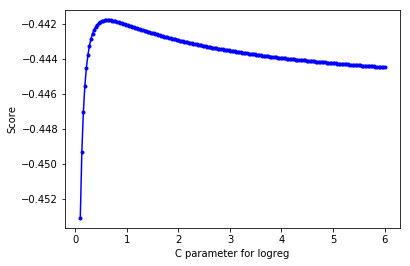

GridSearch for model:  set2
Best score using scoring metric from CV -0.45191
Score in train data from best parameters  0.80056
Score on test data from best parameters  0.78771
Parameters for best score in CV {'C': 5.97035175879397}



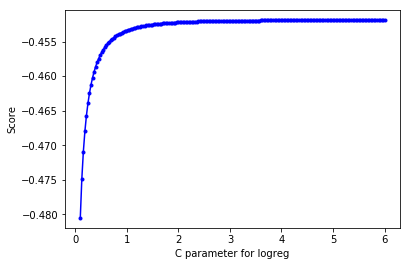

GridSearch for model:  set3
Best score using scoring metric from CV -0.44130
Score in train data from best parameters  0.81461
Score on test data from best parameters  0.80447
Parameters for best score in CV {'C': 1.0190954773869347}



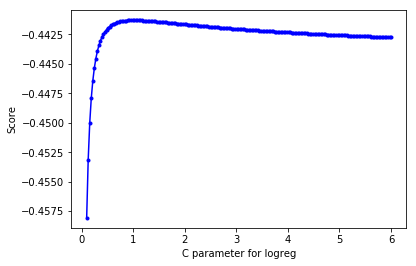

GridSearch for model:  set4
Best score using scoring metric from CV -0.44848
Score in train data from best parameters  0.81461
Score on test data from best parameters  0.78212
Parameters for best score in CV {'C': 0.9894472361809046}



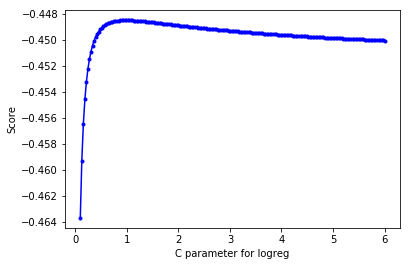

In [24]:
for model, params in models.items():
    print('GridSearch for model: ', model)
    param_grid = [
                {'C':np.linspace(0.1, 6., 200)},
                 ]
    grid_search = GridSearchCV(LogisticRegression(random_state = rng),
                               param_grid, 
                               cv= 10, 
                               n_jobs = 1,
                               scoring= 'neg_log_loss')
    grid_search.fit(params['X_train'], y_train)
    print_grid_search_results(grid_search, params['X_attribs'],
                              params['X_train'], y_train,
                              params['X_test'], y_test, verbose=0)

    #Save useful information to each dataset dictionary
    params['logreg_grid_search'] = grid_search    
    params['clf_logreg'] = grid_search.best_estimator_   
    cvres = grid_search.cv_results_
    scores = np.array([ [j['C'], i] 
                       for i,j in list(zip(cvres['mean_test_score'], 
                                           cvres['params']))])
    plt.plot(scores[:,0], scores[:,1], 'bo-', markersize=3)
    plt.xlabel('C parameter for logreg')
    plt.ylabel('Score')
    plt.show()

#### Score summary from logistic regression

In [25]:
for model, params in models.items():
    print('Model :', model)
    model_eval(params['clf_logreg'], 
               params['X_train'], 
               y_train, 
               params['X_test'], 
               y_test)

Model : set1
Evaluating LogisticRegression
Train score:  0.82303  Test score:  0.81006  Difference  0.012978
Mean score on train set from 10-fold CV:  0.80750   Std. Dev.:  0.04771
Model : set2
Evaluating LogisticRegression
Train score:  0.80056  Test score:  0.78771  Difference  0.012852
Mean score on train set from 10-fold CV:  0.79082   Std. Dev.:  0.04310
Model : set3
Evaluating LogisticRegression
Train score:  0.81461  Test score:  0.80447  Difference  0.010137
Mean score on train set from 10-fold CV:  0.80756   Std. Dev.:  0.04696
Model : set4
Evaluating LogisticRegression
Train score:  0.81461  Test score:  0.78212  Difference  0.032484
Mean score on train set from 10-fold CV:  0.80903   Std. Dev.:  0.04665


### SVC grid search

The optimal hyperparameters for set1 are much different than the other sets, so I will run that one separately

#### Comparing scoring metrics

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 1510 tasks      | elapsed:   13.9s
[Parallel(n_jobs=3)]: Done 2000 out of 2000 | elapsed:   17.7s finished


Scoring metric:  accuracy
Best score using scoring metric from CV  0.83006
Score in train data from best parameters  0.86798
Score on test data from best parameters  0.82123
Parameters for best score in CV {'C': 5.5602680347446185, 'gamma': 0.1}



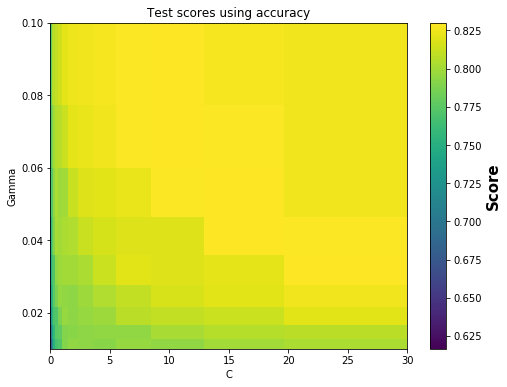

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 1510 tasks      | elapsed:   14.2s


Scoring metric:  roc_auc
Best score using scoring metric from CV  0.86724
Score in train data from best parameters  0.85253
Score on test data from best parameters  0.82123
Parameters for best score in CV {'C': 3.6482899394510615, 'gamma': 0.0774263682681127}



[Parallel(n_jobs=3)]: Done 2000 out of 2000 | elapsed:   19.1s finished


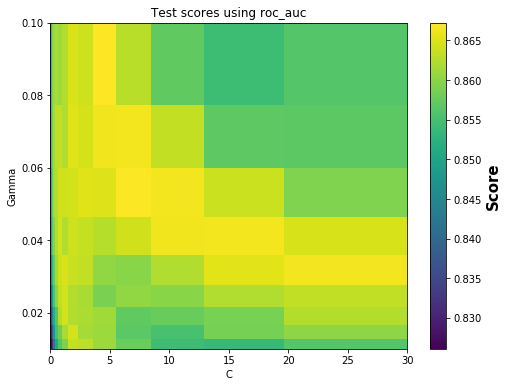

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 1510 tasks      | elapsed:   15.3s
[Parallel(n_jobs=3)]: Done 2000 out of 2000 | elapsed:   19.5s finished


Scoring metric:  average_precision
Best score using scoring metric from CV  0.83994
Score in train data from best parameters  0.84691
Score on test data from best parameters  0.81006
Parameters for best score in CV {'C': 12.915418732752679, 'gamma': 0.027825594022071243}



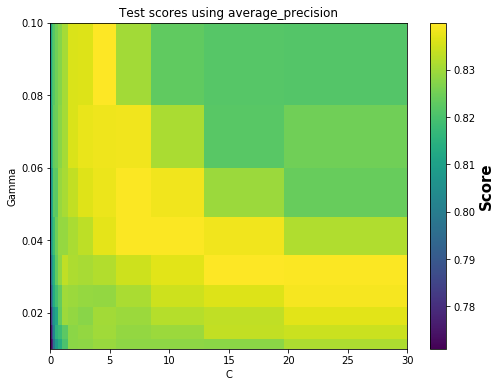

In [26]:
params = models['set1']
for scoring in ['accuracy', 'roc_auc', 'average_precision']:
    param_grid = [
                 {'C':np.geomspace(1e-2, 30., 20), 
                  'gamma':np.geomspace(1e-2, 1e-1, 10),
                 }
              ]

    grid_search = GridSearchCV(SVC(random_state = rng),
                               param_grid, 
                               cv= 10, 
                               n_jobs = 3,
                               scoring= scoring,
                               verbose=1)
    grid_search.fit(params['X_train'], y_train)
    print('Scoring metric: ', scoring)
    print_grid_search_results(grid_search, params['X_attribs'],
                              params['X_train'], y_train,
                              params['X_test'], y_test, verbose=0)
    
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    cvres = grid_search.cv_results_
    plot_params = np.array([[i['C'], i['gamma'],j] 
                            for i, j in zip(list(cvres['params']), 
                                            cvres['mean_test_score'])])

    nC = np.unique(plot_params[:,0]).size
    nG = np.unique(plot_params[:,1]).size
    CC = plot_params[:,0].reshape(nC, nG)
    GG = plot_params[:,1].reshape(nC, nG)
    train_scores = plot_params[:,2].reshape(nC, nG)
    lims = [CC.min(), CC.max(), GG.min(), GG.max()]

    pclr = ax.pcolormesh(CC,GG,train_scores)
    # pclr = ax.imshow(train_scores.T,
    #                  origin='lower',
    #                  extent=lims,
    #                  aspect=np.ptp(CC)/np.ptp(GG))

    fig.colorbar(pclr, shrink=1.0, ax=ax).set_label(label='Score',
                                                    size=15,weight='semibold')
    ax.set_xlabel('C')
    ax.set_ylabel('Gamma')
    ax.set_title('Test scores using ' + scoring)

    plt.show()

While all the scoring methods select hyperparameters that score comparably well, the heatmap for 'accuracy' is poorly defined.  The shallow hyperparameter surface is hard to find an optimal set.  Of the other two, the 'roc_auc' performs a bit better, so I will go with that.

In [27]:
for model, params in models.items():
    print('GridSearch for model: ', model)
    param_grid = [
                 {'C':np.geomspace(1e-1, 15., 15), 
                  'gamma':np.linspace(1e-2, 0.5, 15),
#                   'kernel':['rbf', 'poly']
                 }
              ]

    grid_search = GridSearchCV(SVC(random_state = rng),
                               param_grid, 
                               cv= 10, 
                               n_jobs = 3,
                               scoring= 'roc_auc',
                               verbose=1)
    grid_search.fit(params['X_train'], y_train)
    params['svc_grid_search'] = grid_search
    params['clf_svc'] = grid_search.best_estimator_
    print_grid_search_results(grid_search, params['X_attribs'],
                              params['X_train'], y_train,
                              params['X_test'], y_test, verbose=0)

GridSearch for model:  set1
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=3)]: Done 234 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Done 1134 tasks      | elapsed:   10.7s


Best score using scoring metric from CV  0.86782
Score in train data from best parameters  0.85253
Score on test data from best parameters  0.82682
Parameters for best score in CV {'C': 3.5838588718905897, 'gamma': 0.07999999999999999}

GridSearch for model:  set2
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=3)]: Done 2250 out of 2250 | elapsed:   21.9s finished
[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 1510 tasks      | elapsed:   10.2s


Best score using scoring metric from CV  0.85869
Score in train data from best parameters  0.83848
Score on test data from best parameters  0.80447
Parameters for best score in CV {'C': 7.33197675107872, 'gamma': 0.32499999999999996}

GridSearch for model:  set3
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=3)]: Done 2250 out of 2250 | elapsed:   16.1s finished
[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done 1510 tasks      | elapsed:   11.7s


Best score using scoring metric from CV  0.86621
Score in train data from best parameters  0.81882
Score on test data from best parameters  0.78771
Parameters for best score in CV {'C': 0.1, 'gamma': 0.21999999999999997}

GridSearch for model:  set4
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=3)]: Done 2250 out of 2250 | elapsed:   18.4s finished
[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Done 1510 tasks      | elapsed:   12.7s


Best score using scoring metric from CV  0.86293
Score in train data from best parameters  0.82163
Score on test data from best parameters  0.77654
Parameters for best score in CV {'C': 0.1430326186927546, 'gamma': 0.36}



[Parallel(n_jobs=3)]: Done 2250 out of 2250 | elapsed:   19.8s finished


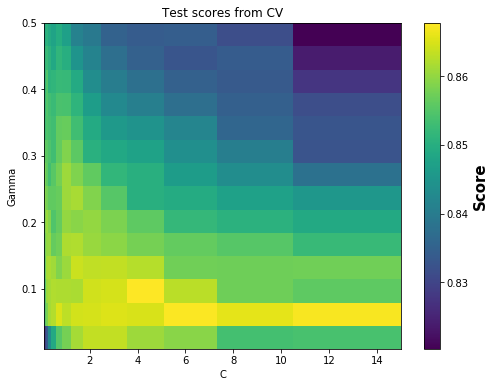

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

cvres = models['set1']['svc_grid_search'].cv_results_
plot_params = np.array([[i['C'], i['gamma'],j] 
                        for i, j in zip(list(cvres['params']), 
                                        cvres['mean_test_score'])])

nC = np.unique(plot_params[:,0]).size
nG = np.unique(plot_params[:,1]).size
CC = plot_params[:,0].reshape(nC, nG)
GG = plot_params[:,1].reshape(nC, nG)
train_scores = plot_params[:,2].reshape(nC, nG)
lims = [CC.min(), CC.max(), GG.min(), GG.max()]

pclr = ax.pcolormesh(CC,GG,train_scores)
# pclr = ax.imshow(train_scores.T,
#                  origin='lower',
#                  extent=lims,
#                  aspect=np.ptp(CC)/np.ptp(GG))

fig.colorbar(pclr, shrink=1.0, ax=ax).set_label(label='Score',
                                                size=15,weight='semibold')
ax.set_xlabel('C')
ax.set_ylabel('Gamma')
ax.set_title('Test scores from CV')

plt.show()

#### Scoring summary for SVC

In [29]:
for model, params in models.items():
    print('Model :', model)
    model_eval(params['clf_svc'], 
               params['X_train'], 
               y_train, 
               params['X_test'], 
               y_test)

Model : set1
Evaluating SVC
Train score:  0.85253  Test score:  0.82682  Difference  0.025712
Mean score on train set from 10-fold CV:  0.82601   Std. Dev.:  0.04695
Model : set2
Evaluating SVC
Train score:  0.83848  Test score:  0.80447  Difference  0.034014
Mean score on train set from 10-fold CV:  0.82175   Std. Dev.:  0.03942
Model : set3
Evaluating SVC
Train score:  0.81882  Test score:  0.78771  Difference  0.031111
Mean score on train set from 10-fold CV:  0.81760   Std. Dev.:  0.03809
Model : set4
Evaluating SVC
Train score:  0.82163  Test score:  0.77654  Difference  0.045093
Mean score on train set from 10-fold CV:  0.80347   Std. Dev.:  0.04829


## Random Forest Classifier

I have not been able to find a set of parameters that does not dramatically overfit or underfit the data.  

In [30]:

for model, params in models.items():
    param_grid = [
                {'n_estimators': np.arange(50, 250, 50), 
#                  'criterion':['gini','entropy'],
                 'max_features': np.arange(4, len(params['X_attribs'])+1, 2),
                 'min_impurity_decrease':[1e-5, 1e-3],
                     'min_samples_leaf': [11],
                     'max_depth': [6],}
#                   'oob_score': [False, True]},
              ]

    grid_search = GridSearchCV(RandomForestClassifier(random_state = rng),
                           param_grid, 
                           cv= 10, 
                           n_jobs = 3,
                           scoring= 'neg_log_loss',
                           verbose=1)
    grid_search.fit(params['X_train'], y_train)
    # print_classifier_scores(grid_search.best_estimator_,
    #                     params['X_train'], y_train,
    #                     params['X_test'], y_test)

    print_grid_search_results(grid_search, params['X_attribs'],
                               params['X_train'], y_train,
                               params['X_test'], y_test, verbose=0)
    params['forest_grid_search'] = grid_search
    params['clf_forest'] = grid_search.best_estimator_


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    8.3s
[Parallel(n_jobs=3)]: Done 374 tasks      | elapsed:   38.6s
[Parallel(n_jobs=3)]: Done 480 out of 480 | elapsed:   51.5s finished


Best score using scoring metric from CV -0.42046
Score in train data from best parameters  0.85674
Score on test data from best parameters  0.81564
Parameters for best score in CV {'max_depth': 6, 'max_features': 8, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 11, 'n_estimators': 200}

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=3)]: Done  80 out of  80 | elapsed:    8.4s finished


Best score using scoring metric from CV -0.42263
Score in train data from best parameters  0.84551
Score on test data from best parameters  0.81006
Parameters for best score in CV {'max_depth': 6, 'max_features': 4, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 11, 'n_estimators': 50}

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 382 tasks      | elapsed:   35.6s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   37.7s finished


Best score using scoring metric from CV -0.42181
Score in train data from best parameters  0.85674
Score on test data from best parameters  0.81564
Parameters for best score in CV {'max_depth': 6, 'max_features': 8, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 11, 'n_estimators': 150}

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    7.2s
[Parallel(n_jobs=3)]: Done 382 tasks      | elapsed:   35.2s


Best score using scoring metric from CV -0.42359
Score in train data from best parameters  0.85534
Score on test data from best parameters  0.81006
Parameters for best score in CV {'max_depth': 6, 'max_features': 8, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 11, 'n_estimators': 50}



[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   37.4s finished


### K-Nearest Neighbors classifier

In [31]:
for model, params in models.items():
    param_grid = [
                    {'n_neighbors':np.arange(2, 20), 
                     'metric':['minkowski', 'manhattan']
                    },
                  ]

    grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid, 
                           cv= 10, 
                           n_jobs = 3,
                           scoring= 'average_precision',
                           verbose=1)
    grid_search.fit(params['X_train'], y_train)
    # print_classifier_scores(grid_search.best_estimator_,
    #                     params['X_train'], y_train,
    #                     params['X_test'], y_test)

    print_grid_search_results(grid_search, params['X_attribs'],
                               params['X_train'], y_train,
                               params['X_test'], y_test, verbose=0)
    params['knn_grid_search'] = grid_search
    params['clf_knn'] = grid_search.best_estimator_



Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best score using scoring metric from CV  0.80107
Score in train data from best parameters  0.82163
Score on test data from best parameters  0.81006
Parameters for best score in CV {'metric': 'manhattan', 'n_neighbors': 14}

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=3)]: Done 360 out of 360 | elapsed:    1.9s finished


Best score using scoring metric from CV  0.82081
Score in train data from best parameters  0.82022
Score on test data from best parameters  0.82123
Parameters for best score in CV {'metric': 'manhattan', 'n_neighbors': 17}

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=3)]: Done 360 out of 360 | elapsed:    1.1s finished


Best score using scoring metric from CV  0.81440
Score in train data from best parameters  0.81461
Score on test data from best parameters  0.76536
Parameters for best score in CV {'metric': 'minkowski', 'n_neighbors': 18}

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=3)]: Done 360 out of 360 | elapsed:    1.5s finished


Best score using scoring metric from CV  0.80290
Score in train data from best parameters  0.81461
Score on test data from best parameters  0.77654
Parameters for best score in CV {'metric': 'manhattan', 'n_neighbors': 19}



[Parallel(n_jobs=3)]: Done 360 out of 360 | elapsed:    1.8s finished


# Load the test data, train the full training set using parameters from gridsearchCV, transform the test set, predict survival

In [41]:
test_data = pd.read_csv('titanic_test.csv', index_col=0)
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Use all of the available train data to train final model using the parameters determined from the split test/train set

In [43]:
full_models = {}
full_models['set1'] = {}
#All features
full_models['set1']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 'Cabin_bool', 'Family_bool',
                              'Shared_ticket']
full_models['set1']['num_attrs'] = ['Fare', 'Age', 'Family_total', 'Name_len']
full_models['set1']['cat_encode'] = 'OneHot'
full_models['set1']['num_scaling'] = 'std_scaler'

#Minimal set of effective features
full_models['set2'] = {}
full_models['set2']['cat_attrs'] = ['Pclass', 'Sex']
full_models['set2']['num_attrs'] = ['Fare', 'Age']
full_models['set2']['cat_encode'] = 'OneHot'
full_models['set2']['num_scaling'] = 'std_scaler'

#A moderate collection, the ones used in the preliminary check
full_models['set3'] = {}
full_models['set3']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 'Cabin_bool']
full_models['set3']['num_attrs'] = ['Fare', 'Age', 'Family_total']
full_models['set3']['cat_encode'] = 'OneHot'
full_models['set3']['num_scaling'] = 'std_scaler'

#One last variation
full_models['set4'] = {}
full_models['set4']['cat_attrs'] = ['Pclass', 'Sex', 'Deck', 
                               'Family_bool', 'Cabin_bool']
full_models['set4']['num_attrs'] = ['Fare', 'Age']
full_models['set4']['cat_encode'] = 'OneHot'
full_models['set4']['num_scaling'] = 'std_scaler'

#Fit all full_models
fit_pipelines(full_models, X, test_data, df, verbose=0)

Fitting model  set1
Fitting model  set2
Fitting model  set3
Fitting model  set4


## Prediction on test data

After trying a few different ML models and feature sets, I obtained a new high score for myself of 0.79425!

This was accomplished using the RandomForestClassifier.

In [44]:
for model, params in full_models.items():
    params['clf_forest'] = RandomForestClassifier(**models[model]['forest_grid_search'].best_params_,  
                   random_state=rng)
    params['clf_forest'].fit(params['X_train'], y_tot)

In [45]:
model_eval(full_models['set1']['clf_forest'], full_models['set1']['X_train'],
          y_tot, full_models['set1']['X_train'], y_tot)

Evaluating RandomForestClassifier
Train score:  0.85185  Test score:  0.85185  Difference      0.0
Mean score on train set from 10-fold CV:  0.81032   Std. Dev.:  0.03427


In [46]:
test_y = full_models['set1']['clf_forest'].predict(full_models['set1']['X_test'])
result = pd.DataFrame(data=test_y, index=test_data.index, columns=['Survived'])
result.to_csv('submission1_titanic.csv')